# **Занятие 5. Классификация изображений**

https://vk.com/lambda_brain

Классификация изображений -- это уже полноценная задача реального мира. Самое приятное здесь в том, что нету качественного алгоритмического отличия классификации изображений от классификации других наборов данных. Нейронные сети работают таким магическим образом, что мы просто подаём им на вход наборы "байтов", и не важно, что это -- абстрактные значения функций или пикселы изображений, они все анализируются нейросетью по единой схеме.

Мы познакомимся с основными принципами классификации изображений в PyTorch, а также изучим смежные вопросы, связанные с загрузкой объёмных датасетов с изображениями в программу и их удобной визуализацией.


# MNIST



---


В качестве первого примера воспользуемся распространённым датасетом изображений **MNIST**, на котором создано наверное максимальное количество обучающих уроков по нейронным сетям.

MNIST подготовлен **Яном ЛеКуном** -- ведущим мировым специалистом по нейронным сетям, и представляет собой датасет для обучения распознаванию рукописных цифр. Обучающая выборка содержит 60,000 изображений, и тестовая -- 10,000. Каждое изображение чёрно-белое размером 28x28 пикселов.

Импортируем нужные модули:


In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms


Задаём гипер-параметры:

In [13]:

input_size = 28*28     # Размер изображения в точках
hidden_size = 500      # Количество нейронов в скрытом слое
num_classes = 10       # Количество распознающихся классов (10 цифр)
n_epochs = 5          # Количество эпох
batch_size = 4         # Размер мини-пакета входных данных
lr = 0.01              # Скорость обучения

Большое количество готовых датасетов и различные удобные методы их загрузки и обработки собраны в модуле torchvision. Имеется в нём конечно и MNIST.

В конструкторе датасета MNIST указывается, как правило, каталог root, где будет локально размещён соответствующий датасет, download -- необходимость скачивания датасета для его локального использования, train -- признак, является ли данный датасет обучающим или тестовым, и трансформация transform, которую надо выполнить над данным датасетом. Последняя фича весьма полезна, потому что исходные изображения нередко требуется предварительно обрабатывать под конкретный формат их дальнейшего анализа. В нашем случае просто укажем стандартную трансформацию преобразования входных данных в тензоры.

Убедимся, что размеры датасета совпадают с официально объявленными.


In [5]:
import torchvision.transforms as transforms
mnist_trainset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print(len(mnist_trainset))
print(len(mnist_testset))

100.0%
100.0%
100.0%
100.0%

60000
10000


Так как наш датасет большой по размеру, обрабатывать его надо небольшими порциями, мини-пакетами, как рассказывалось во втором занятии -- с помощью загрузчиков данных DataLoader.

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset,
                                           batch_size=batch_size,
                                           shuffle=True) # загрузчик обучающих данных
test_loader = torch.utils.data.DataLoader(dataset=mnist_testset,
                                          batch_size=batch_size,
                                          shuffle=False) # загрузчик тестовых данных

Добавим наш стандартный шаг обучения.

In [19]:
# импортируем нужные библиотеки
import torch
import numpy as np # всегда пригодится :)
from torch.nn import Linear, Sigmoid

# инициализируем девайс
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# добавляем типовую функцию "шаг обучения"
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

Структура нашей модели будет представлять собой двуслойную нейронную сеть -- она ничем не отличается от модели, применявшейся в прошлом занятии при анализе абстрактного датасета (линейный вход + ReLU + линейный выход).

Воспользуемся лоссом CrossEntropyLoss() и методом оптимизации Adam.

Обратите внимание, что мы задаём уже не тысячи, а **всего две эпохи** -- процесс обучения на таком довольно объёмном датасете потребует уже прилично времени (несколько минут на одну эпоху).

Единственное дополнение -- мы применяем метод reshape(-1, 28 * 28), чтобы изменить входной трёхмерный формат изображения 1x28x28 (глубина цветности x размеры) на нужный нам одномерный вектор длиной 784 значения. Параметр -1 означает, что преобразование выполняется в одномерный результат.


In [21]:
from torch import optim, nn


model = torch.nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes))
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)
    print(epoch)

print(model.state_dict())
print(loss)


0
1
OrderedDict([('0.weight', tensor([[-0.0065, -0.0295, -0.0172,  ..., -0.0077, -0.0317,  0.0272],
        [-0.0306,  0.0149,  0.0325,  ...,  0.0018,  0.0324, -0.0316],
        [-0.0016, -0.0256,  0.0182,  ..., -0.0073, -0.0060,  0.0125],
        ...,
        [ 0.0243, -0.0074, -0.0027,  ..., -0.0318,  0.0170, -0.0274],
        [ 0.0165,  0.0220,  0.0113,  ..., -0.0287, -0.0342, -0.0102],
        [ 0.0004, -0.0285,  0.0235,  ..., -0.0226,  0.0311,  0.0276]])), ('0.bias', tensor([-3.6393e-02, -1.1639e-01, -5.0114e-02, -4.8848e-01, -7.1532e-02,
        -3.4722e-01, -1.8594e-02, -4.5827e-02, -9.0146e-02,  8.7780e-02,
        -4.9195e-01, -4.1775e-01, -2.6505e-01, -3.7672e-01, -6.5317e-02,
        -2.6545e+00, -3.5798e-01, -8.3253e-01, -1.9934e+00, -2.3268e-01,
        -7.2201e-02, -6.4401e-01, -6.4924e-02, -1.0624e-01, -4.2828e-02,
        -7.8051e-01, -3.8578e-01, -2.9336e-02, -1.1323e-01, -3.6897e-01,
        -8.8965e-02, -5.8279e-01, -6.2851e-02, -8.9032e-02, -4.6236e-01,
        -3.7

Теперь проверим, с какой точностью наша модель проверит 10,000 тестовых изображений:

In [18]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 93.28 %


Около 90% -- это очень хороший результат для тренировки всего в течение пяти минут за две эпохи. Обратите внимание, что обученная модель время на распознавание даже такого приличного по объёму датасета уже практически не тратит.


---



Вычисление, конечно, может занимать не минуты, а часы, сутки, недели и месяцы работы. Чтобы продолжить работу с нашей обученной моделью уже в прикладных задачах, нам надо прежде всего её сохранить в файле (в PyTorch принято, что расширение файла с полностью сохранённой моделью -- .pt).


In [10]:
torch.save(model, 'mnist_full.pt')

Сохранение выполняется в виртуальной машине гугла, где мы загрузили датасет MNIST. Загрузка модели выполняется так же просто:

In [11]:
model = torch.load("mnist_full.pt")
model.eval()

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.container.Sequential was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.nn.modules.container.Sequential])` or the `torch.serialization.safe_globals([torch.nn.modules.container.Sequential])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

После загрузки модели надо обязательно выполнить её метод **eval()** -- это означает, что мы будем пользоваться моделью в режиме её эксплуатации, а не в режимах обучения или каких-то других.

##**Задание**

Попробуйте повысить точность нашей модели:

* увеличьте количество эпох;
* увеличьте количество нейронов;
* добавьте новые скрытые слои;
* измените размер мини-пакета.


---

* При желании придумайте, как визуализировать работу модели на тестовых данных (показывать изображения и соответствующий им распознанный класс).





Далее мы рассмотрим работу с более сложным датасетом изображений (котики и пёсики), которому потребуется предварительная обработка.

# Было бы интересно создать инфраструктуру для проверки различных гиперпараметров


Config {'hidden_size': 500, 'batch_size': 14, 'lr': 0.005} | Epoch 8 | Точность: 97.24 %
Config {'hidden_size': 500, 'batch_size': 20, 'lr': 0.005} | Epoch 8 | Точность: 96.96 %
Config {'hidden_size': 500, 'batch_size': 26, 'lr': 0.005} | Epoch 8 | Точность: 97.07 %
Config {'hidden_size': 500, 'batch_size': 32, 'lr': 0.005} | Epoch 8 | Точность: 97.33 %
Config {'hidden_size': 500, 'batch_size': 38, 'lr': 0.005} | Epoch 8 | Точность: 97.37 %
Config {'hidden_size': 500, 'batch_size': 44, 'lr': 0.005} | Epoch 8 | Точность: 97.32 %


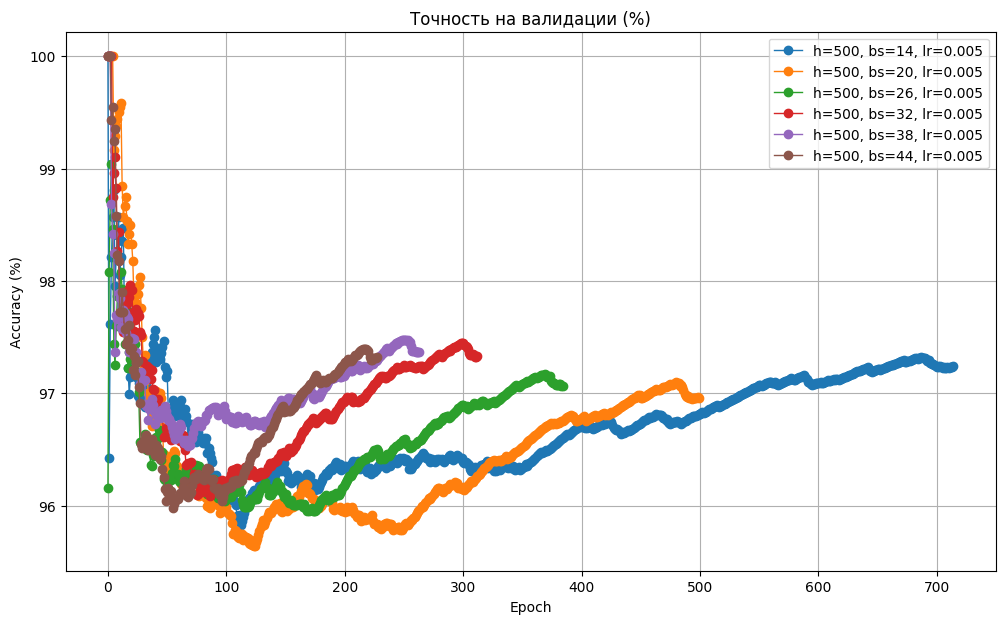

In [46]:
import torch
from torch import optim, nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class ResearchInfra:

    def __init__(self):
        self.input_size = 28 * 28
        self.num_classes = 10
        self.n_epochs = 9

        # данные
        transform = transforms.ToTensor()
        self.mnist_train = dsets.MNIST(root='./data', train=True, download=True, transform=transform)
        self.mnist_test = dsets.MNIST(root='./data', train=False, download=True, transform=transform)

    def get_configs(self):
        configs = [
            {"hidden_size": 500, "batch_size": 14, "lr": 0.005},
            {"hidden_size": 500, "batch_size": 20, "lr": 0.005},
            {"hidden_size": 500, "batch_size": 26, "lr": 0.005},
            {"hidden_size": 500, "batch_size": 32, "lr": 0.005},
            {"hidden_size": 500, "batch_size": 38, "lr": 0.005},
            {"hidden_size": 500, "batch_size": 44, "lr": 0.005}
        ]
        return configs

    def make_loaders(self, batch_size):
        train_loader = torch.utils.data.DataLoader(dataset=self.mnist_train,
                                                   batch_size=batch_size,
                                                   shuffle=True)

        test_loader = torch.utils.data.DataLoader(dataset=self.mnist_test,
                                                  batch_size=batch_size,
                                                  shuffle=False)

        return train_loader, test_loader

    @staticmethod
    def make_train_step(model, loss_fn, optimizer):
        def train_step(x, y):
            model.train()
            yhat = model(x)
            loss = loss_fn(yhat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            return loss.item()
        return train_step

    def run_experiment(self, config):

        hidden_size = config["hidden_size"]
        batch_size = config["batch_size"]
        lr = config["lr"]

        model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        ).to(device)

        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader, test_loader = self.make_loaders(batch_size)
        train_step = self.make_train_step(model, loss_fn, optimizer)

        loss_history = []

        for epoch in range(self.n_epochs):
            for images, labels in train_loader:
                images = images.reshape(-1, 28*28).to(device)
                labels = labels.to(device)

                loss = train_step(images, labels)
            # print(loss)

        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.reshape(-1, 28*28).to(device)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss_history.append(100 * correct / total)

        print(f"Config {config} | Epoch {epoch} | Точность: {100 * correct / total:.2f} %")


        return loss_history


research_infra = ResearchInfra()
configs = research_infra.get_configs()

results = []

for cfg in configs:
    history = research_infra.run_experiment(cfg)
    results.append({
        "config": cfg,
        "loss_history": history
    })

plt.figure(figsize=(12, 7))
for result in results:
    plt.plot(result['loss_history'], marker='o', linewidth=1,  # тонкая линия
             label=f"h={result['config']['hidden_size']}, "
                   f"bs={result['config']['batch_size']}, "
                   f"lr={result['config']['lr']}")

plt.title("Точность на валидации (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
